# Climate Change Exploration: Maunalua Bay, Oahu, Hawai'i
## Fall 2021
### Elmera Azadpour
### 2021-12-08
All scripts and data can be accessed from [Aloha Aina Repo](https://github.com/aloha-aina/Aloha-Aina-Master)

Code derived from [CMIP6 PanGeo Gallery](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/precip_frequency_change.html)

Note: This analysis pulls data from CNRM-ESM2-1 only, you will find two other notebook files that will pull from other climate model sources.

In [1]:
## import libraries:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
import s3fs
import kedro
import nc_time_axis
import plotly.express as px
import metpy
from metpy.units import units

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
## CMIP6 Public Data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head(50)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
5,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
6,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
7,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,huss,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
8,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
9,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfss,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
## Query for projection CMIP6 data
df_3hr_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr')]
len(df_3hr_pr)

run_counts = df_3hr_pr.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id         experiment_id     
BCC-CSM2-MR       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1        highresSST-present     1
                  historical             3
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1-HR     highresSST-present     1
CNRM-ESM2-1       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
GFDL-CM4          1pctCO2                2
                  abrupt-4xCO2           2
                  amip                   2
                  historical             2
                  piControl              2
GFDL-CM4C192     

<div>
<center>
<img src="https://github.com/aloha-aina/Aloha-Aina-Master/blob/main/img/cmip6_ssp.png?raw=1" width="600"/>
<br>
Fig. 1: Future and historical CO2 emissions scenarios featured in CMIP6
<br>
Source: https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained
</center>
</div>
<br>

### Pulling CNRM-ESM2-1, ssp2-4.5 Projection

In [4]:
## querty for 3hr, precipitaion for ssp 2-4.5 projection from CNRM-ESM2-1
df_3hr_ssp245_CNRM_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr') & (df.experiment_id== 'ssp245') & (df.source_id== 'CNRM-ESM2-1') ]
len(df_3hr_ssp245_CNRM_pr)
df_3hr_ssp245_CNRM_pr 

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
68835,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp245,r1i1p1f2,3hr,pr,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190328


In [5]:
## pull data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_3hr_ssp245_CNRM_pr.zstore.values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds_proj = xr.open_zarr(mapper, consolidated=True)
ds_proj

gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp245/r1i1p1f2/3hr/pr/gr/v20190328/


<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, time: 251288, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time         (time) datetime64[ns] 2015-01-01T01:30:00 ... 2100-12-31T22:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(62822, 1), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_ssp245_r1i1p1f2
    activity_id:            ScenarioMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/215d187a-7fa5-41cd-a59b-7fe164306a61...
    version_id:             v20190328

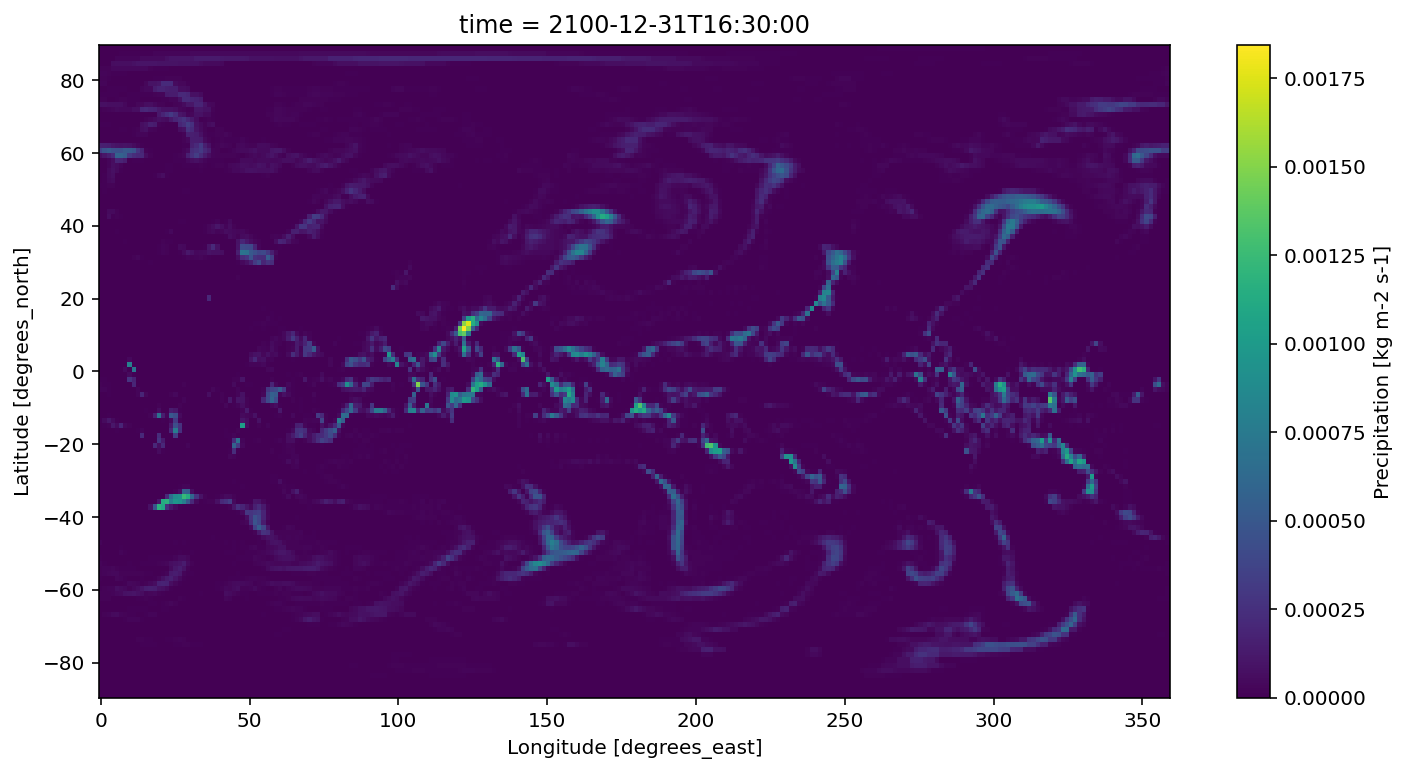

In [6]:
## Plot a map from a specific date: global coverage
ds_proj.pr.sel(time='2100-12-31T16:30:00.000000000').squeeze().plot()

In [1]:
# # Create logical masks for lat and lon variables for oahu 
# bouding box: -158.5698,20.9057,-157.406,22.0022
mask_lon = (ds_proj.pr.lon >= 201.43) & (ds_proj.pr.lon <= 202.59) 
mask_lat = (ds_proj.pr.lat >= 20.91) & (ds_proj.pr.lat <= 22.00)

NameError: name 'ds_proj' is not defined

In [7]:
# Apply lat/lon masks to the field, then calculate averages over the lat and lon dimensions
oahu_pr_proj=ds_proj.pr.where(mask_lon & mask_lat, drop = True)

## remove times associated with leap years (remove feb 29 from all recorded years)
oahu_pr_proj = oahu_pr_proj.sel(time=~((oahu_pr_proj.time.dt.month == 2) & (oahu_pr_proj.time.dt.day == 29)))
oahu_pr_proj

## group by day of year and avg by day
oahu_pr_proj['dayofyear'] = xr.DataArray(oahu_pr_proj.indexes['time'].strftime('%Y-%m-%d'), coords=oahu_pr_proj.time.coords)
oahu_pr_proj_avg = oahu_pr_proj.groupby('dayofyear').mean('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_avg

<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [8]:
## daily sum of precip ssp3-7.0 Projection 
oahu_pr_proj_sum_245 = oahu_pr_proj.groupby('dayofyear').sum('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_sum_245

<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [9]:
# Make metpy recognize the units
oahu_pr_proj_sum_245 = oahu_pr_proj_sum_245.metpy.quantify()

# convert kg/m2/sec to in/day
density_water = units('kg / m^3') * 1000
oahu_pr_proj_converted_int_ssp245_sum = (oahu_pr_proj_sum_245 / density_water)
oahu_pr_proj_converted_int_ssp245_sum = oahu_pr_proj_converted_int_ssp245_sum.metpy.convert_units('inches / day')
oahu_pr_proj_converted_int_ssp245_sum = oahu_pr_proj_converted_int_ssp245_sum.mean("lon").mean("lat")
oahu_pr_proj_converted_int_ssp245_sum

<xarray.DataArray 'pr' (dayofyear: 31390)>
<Quantity(dask.array<mean_agg-aggregate, shape=(31390,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>, 'inch / day')>
Coordinates:
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'

<div>
<center>
<img src="https://github.com/aloha-aina/Aloha-Aina-Master/blob/main/img/bb_oahu.png?raw=1" width="600"/>
<br>
Fig. 2: Bouding box coordinates used for projection analysis
<br>
Source: https://boundingbox.klokantech.com/
</center>
</div>
<br>

In [49]:
# Cast our xarray to dataframe -- daily averages 
oahu_pr_proj_df = oahu_pr_proj_converted_int.to_dataframe().reset_index()
oahu_pr_proj_df.head(20)

,dayofyear,pr
0,2015-01-01,0.000390
1,2015-01-02,0.001306
2,2015-01-03,0.022132
3,2015-01-04,0.196844
4,2015-01-05,0.441790
5,2015-01-06,0.076026
6,2015-01-07,0.059438
7,2015-01-08,0.060714
8,2015-01-09,0.026974
9,2015-01-10,0.005410


In [10]:
# Cast our xarray to dataframe for daily sums
oahu_pr_proj_converted_int_ssp245_sum_df = oahu_pr_proj_converted_int_ssp245_sum.to_dataframe().reset_index()
oahu_pr_proj_converted_int_ssp245_sum_df.head(20)

,dayofyear,pr
0,2015-01-01,0.003117
1,2015-01-02,0.010450
2,2015-01-03,0.177055
3,2015-01-04,1.574751
4,2015-01-05,3.534323
5,2015-01-06,0.608212
6,2015-01-07,0.475508
7,2015-01-08,0.485709
8,2015-01-09,0.215790
9,2015-01-10,0.043283


In [66]:
## to export df,daily avg
## oahu_pr_proj_df.to_csv('oahu_ssp245_2015_2100_avg.csv', index = False)

In [11]:
## to export df, daily sum
oahu_pr_proj_converted_int_ssp245_sum_df.to_csv('oahu_ssp245_2015_2100_total.csv', index = False)

### Exploring CNRM-ESM2-1, ssp3-7.0 Projection

In [19]:
## querty for 3hr, precipitaion for ssp 3-7.0 projection from CNRM-ESM2-1
df_3hr_ssp370_CNRM_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr') & (df.experiment_id== 'ssp370') & (df.source_id== 'CNRM-ESM2-1') ]
len(df_3hr_ssp370_CNRM_pr)
df_3hr_ssp370_CNRM_pr 

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
69219,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp370,r1i1p1f2,3hr,pr,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190328


In [20]:
## pull data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore2 = df_3hr_ssp370_CNRM_pr.zstore.values[-1]
print(zstore2)

# create a mutable-mapping-style interface to the store
mapper2 = fsspec.get_mapper(zstore2)

# open it using xarray and zarr
ds_proj_ssp370 = xr.open_zarr(mapper2, consolidated=True)
ds_proj_ssp370

gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp370/r1i1p1f2/3hr/pr/gr/v20190328/


<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, time: 251288, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time         (time) datetime64[ns] 2015-01-01T01:30:00 ... 2100-12-31T22:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(62822, 1), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (time, lat, lon) float32 dask.array<chunksize=(449, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_ssp370_r1i1p1f2
    activity_id:            ScenarioMIP AerChemMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-11-03;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/2a291f7e-b9c9-4c68-b33b-cbfc153a587f...
    version_id:             v20190328

In [21]:
# Apply lat/lon masks to the field, then calculate averages over the lat and lon dimensions
oahu_pr_proj_ssp370=ds_proj_ssp370.pr.where(mask_lon & mask_lat, drop = True)

## remove times associated with leap years (remove feb 29 from all recorded years)
oahu_pr_proj_ssp370 = oahu_pr_proj_ssp370.sel(time=~((oahu_pr_proj_ssp370.time.dt.month == 2) & (oahu_pr_proj_ssp370.time.dt.day == 29)))
oahu_pr_proj_ssp370

## group by day of year and avg by day
oahu_pr_proj_ssp370['dayofyear'] = xr.DataArray(oahu_pr_proj_ssp370.indexes['time'].strftime('%Y-%m-%d'), coords=oahu_pr_proj_ssp370.time.coords)
oahu_pr_proj_ssp370_avg = oahu_pr_proj_ssp370.groupby('dayofyear').mean('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_ssp370_avg


<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [22]:
## daily sum of precip ssp3-7.0 projection
oahu_pr_proj_sum_370 = oahu_pr_proj_ssp370.groupby('dayofyear').sum('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_sum_370

<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [23]:
# Make metpy recognize the units
oahu_pr_proj_ssp370_sum = oahu_pr_proj_sum_370.metpy.quantify()

# convert kg/m2/sec to in/day
density_water = units('kg / m^3') * 1000
oahu_pr_proj_ssp370_converted_int_sum = (oahu_pr_proj_ssp370_sum / density_water)
oahu_pr_proj_ssp370_converted_int_sum = oahu_pr_proj_ssp370_converted_int_sum.metpy.convert_units('inches / day')
oahu_pr_proj_ssp370_converted_int_sum = oahu_pr_proj_ssp370_converted_int_sum.mean("lon").mean("lat")
oahu_pr_proj_ssp370_converted_int_sum

<xarray.DataArray 'pr' (dayofyear: 31390)>
<Quantity(dask.array<mean_agg-aggregate, shape=(31390,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>, 'inch / day')>
Coordinates:
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.4963051 , -0.3963051 , -0.29630512, -0.19630511, -0.09630511,
         0.00369489,  0.10369489,  0.2036949 ,  0.3036949 ,  0.4036949 ,
         0.5036949 ], dtype=float32),
 <BarContainer object of 10 artists>)

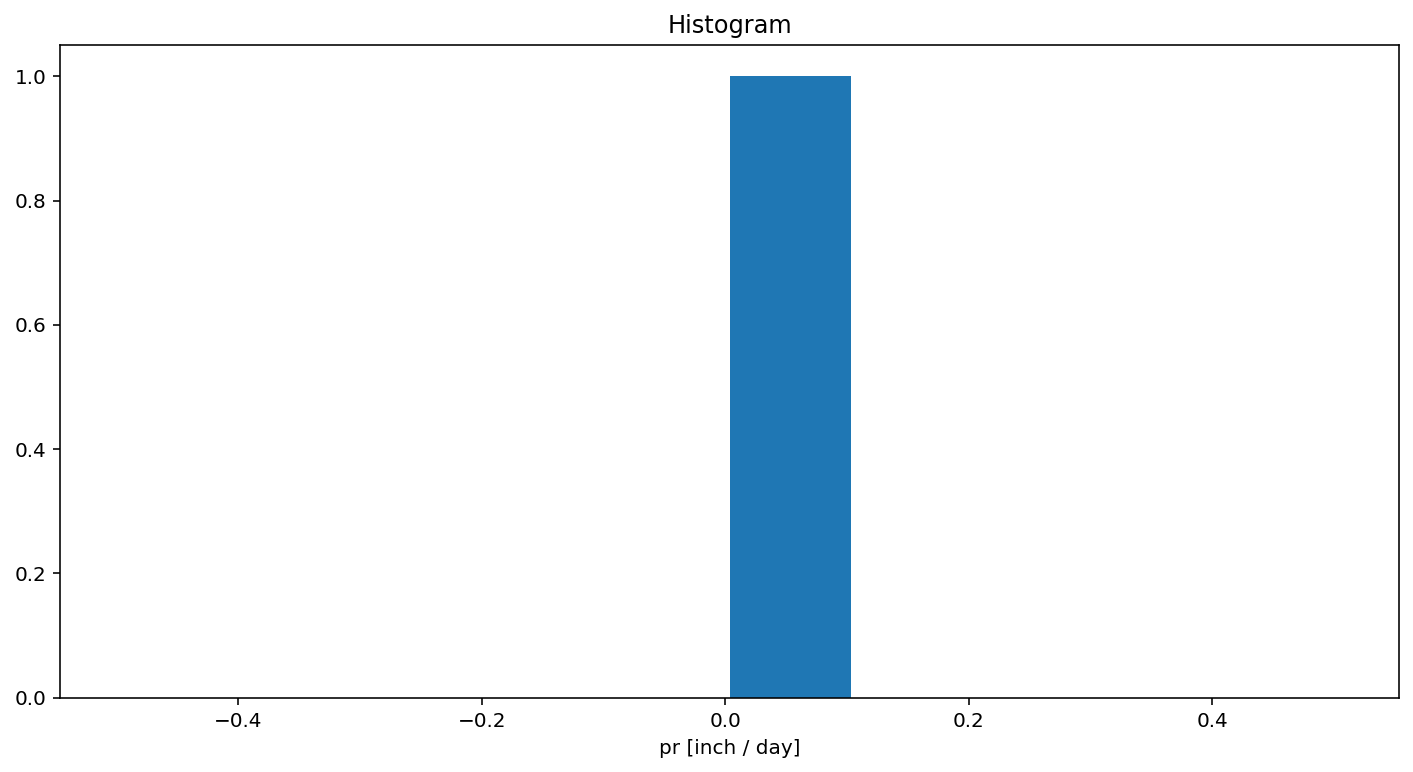

In [15]:
## Plot a plot from a projected ssp370 date and lat and long for Oahu.
oahu_pr_proj_ssp370_converted_int.sel(dayofyear='2050-12-01').squeeze().plot()

In [16]:
# Cast our xarray to dataframe -- daily avg 
oahu_pr_proj_ssp370_df = oahu_pr_proj_ssp370_converted_int.to_dataframe().reset_index()
oahu_pr_proj_ssp370_df.head(20)

,dayofyear,pr
0,2015-01-01,3.701659e-04
1,2015-01-02,2.282345e-03
2,2015-01-03,1.025546e-02
3,2015-01-04,3.492512e-01
4,2015-01-05,9.594570e-01
5,2015-01-06,2.072181e-01
6,2015-01-07,1.574929e-01
7,2015-01-08,5.034250e-02
8,2015-01-09,4.010621e-02
9,2015-01-10,2.340790e-02


In [24]:
# Cast our xarray to dataframe -- daily sum 
oahu_pr_proj_ssp370_df_sum = oahu_pr_proj_ssp370_converted_int_sum.to_dataframe().reset_index()
oahu_pr_proj_ssp370_df_sum.head(20)

,dayofyear,pr
0,2015-01-01,2.961327e-03
1,2015-01-02,1.825876e-02
2,2015-01-03,8.204365e-02
3,2015-01-04,2.794009e+00
4,2015-01-05,7.675656e+00
5,2015-01-06,1.657745e+00
6,2015-01-07,1.259943e+00
7,2015-01-08,4.027400e-01
8,2015-01-09,3.208497e-01
9,2015-01-10,1.872632e-01


In [23]:
## to export df
# oahu_pr_proj_ssp370_df.to_csv('oahu_ssp370_2015_2100.csv', index = False)

In [25]:
## to export df, daily total ssp370
oahu_pr_proj_ssp370_df_sum.to_csv('oahu_ssp370_2015_2100_total.csv', index = False)

### Exploring CNRM-ESM2-1, ssp5-8.5 Projection

In [26]:
## querty for 3hr, precipitaion for ssp 5-8.5 projection from CNRM-ESM2-1
df_3hr_ssp585_CNRM_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr') & (df.experiment_id== 'ssp585') & (df.source_id== 'CNRM-ESM2-1') ]
len(df_3hr_ssp585_CNRM_pr)
df_3hr_ssp585_CNRM_pr

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
69200,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp585,r1i1p1f2,3hr,pr,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190328


In [27]:
## pull data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore3 = df_3hr_ssp585_CNRM_pr.zstore.values[-1]
print(zstore3)

# create a mutable-mapping-style interface to the store
mapper3 = fsspec.get_mapper(zstore3)

# open it using xarray and zarr
ds_proj_ssp585 = xr.open_zarr(mapper3, consolidated=True)
ds_proj_ssp585

gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp585/r1i1p1f2/3hr/pr/gr/v20190328/


<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, time: 251288, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time         (time) datetime64[ns] 2015-01-01T01:30:00 ... 2100-12-31T22:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(62822, 1), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_ssp585_r1i1p1f2
    activity_id:            ScenarioMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-08-26;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/6fb366f9-6ed1-47fe-918c-08fa5ca8baa3...
    version_id:             v20190328

In [28]:
# Apply lat/lon masks to the field, then calculate averages over the lat and lon dimensions
oahu_pr_proj_ssp585=ds_proj_ssp585.pr.where(mask_lon & mask_lat, drop = True)

## remove times associated with leap years (remove feb 29 from all recorded years )
oahu_pr_proj_ssp585 = oahu_pr_proj_ssp585.sel(time=~((oahu_pr_proj_ssp585.time.dt.month == 2) & (oahu_pr_proj_ssp585.time.dt.day == 29)))
oahu_pr_proj_ssp585

## group by day of year and avg by day
oahu_pr_proj_ssp585['dayofyear'] = xr.DataArray(oahu_pr_proj_ssp585.indexes['time'].strftime('%Y-%m-%d'), coords=oahu_pr_proj_ssp585.time.coords)
oahu_pr_proj_ssp585_avg = oahu_pr_proj_ssp585.groupby('dayofyear').mean('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_ssp585_avg

<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [29]:
## daily sum of precip ssp5-8.5 Projection 
oahu_pr_proj_sum_585 = oahu_pr_proj_ssp585.groupby('dayofyear').sum('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_sum_585

<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [30]:
# Make metpy recognize the units
oahu_pr_proj_ssp585_sum = oahu_pr_proj_sum_585.metpy.quantify()

# convert kg/m2/sec to in/day
density_water = units('kg / m^3') * 1000
oahu_pr_proj_ssp585_converted_int_sum = (oahu_pr_proj_ssp585_sum / density_water)
oahu_pr_proj_ssp585_converted_int_sum = oahu_pr_proj_ssp585_converted_int_sum.metpy.convert_units('inches / day')
oahu_pr_proj_ssp585_converted_int_sum = oahu_pr_proj_ssp585_converted_int_sum.mean("lon").mean("lat")
oahu_pr_proj_ssp585_converted_int_sum

<xarray.DataArray 'pr' (dayofyear: 31390)>
<Quantity(dask.array<mean_agg-aggregate, shape=(31390,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>, 'inch / day')>
Coordinates:
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'

In [29]:
# Cast our xarray to dataframe
oahu_pr_proj_ssp585_df = oahu_pr_proj_ssp585_converted_int.to_dataframe().reset_index()
oahu_pr_proj_ssp585_df.head(20)

,dayofyear,pr
0,2015-01-01,0.000311
1,2015-01-02,0.001061
2,2015-01-03,0.019240
3,2015-01-04,0.289843
4,2015-01-05,0.766865
5,2015-01-06,0.173856
6,2015-01-07,0.088689
7,2015-01-08,0.044970
8,2015-01-09,0.023198
9,2015-01-10,0.016240


In [31]:
# Cast our xarray to dataframe
oahu_pr_proj_ssp585_df_sum = oahu_pr_proj_ssp585_converted_int_sum.to_dataframe().reset_index()
oahu_pr_proj_ssp585_df_sum.head(20)

,dayofyear,pr
0,2015-01-01,0.002490
1,2015-01-02,0.008486
2,2015-01-03,0.153917
3,2015-01-04,2.318743
4,2015-01-05,6.134923
5,2015-01-06,1.390850
6,2015-01-07,0.709511
7,2015-01-08,0.359761
8,2015-01-09,0.185582
9,2015-01-10,0.129921


In [30]:
## to export df
# oahu_pr_proj_ssp585_df.to_csv('oahu_ssp585_2015_2100.csv', index = False)

In [32]:
## to export df, daily total ssp585
oahu_pr_proj_ssp585_df_sum.to_csv('oahu_ssp585_2015_2100_total.csv', index = False)

### Exploring CNRM-ESM2-1, ssp1-2.6 Projection

In [33]:
## querty for 3hr, precipitaion for ssp 1-2.6 from CNRM-ESM2-1
df_3hr_ssp126_CNRM_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr') & (df.experiment_id== 'ssp126') & (df.source_id== 'CNRM-ESM2-1') ]
len(df_3hr_ssp126_CNRM_pr)
df_3hr_ssp126_CNRM_pr

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
69045,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp126,r1i1p1f2,3hr,pr,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190328


In [34]:
## pull data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore4 = df_3hr_ssp126_CNRM_pr.zstore.values[-1]
print(zstore4)

# create a mutable-mapping-style interface to the store
mapper4 = fsspec.get_mapper(zstore4)

# open it using xarray and zarr
ds_proj_ssp126 = xr.open_zarr(mapper4, consolidated=True)
ds_proj_ssp126

gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp126/r1i1p1f2/3hr/pr/gr/v20190328/


<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, time: 251288, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time         (time) datetime64[ns] 2015-01-01T01:30:00 ... 2100-12-31T22:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(62822, 1), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (time, lat, lon) float32 dask.array<chunksize=(449, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_ssp126_r1i1p1f2
    activity_id:            ScenarioMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-11-03;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/6255501d-a196-47b5-be0f-7d61a687e6e1...
    version_id:             v20190328

In [35]:
# Apply lat/lon masks to the field, then calculate averages over the lat and lon dimensions
oahu_pr_proj_ssp126=ds_proj_ssp126.pr.where(mask_lon & mask_lat, drop = True)

## remove times associated with leap years (remove feb 29 from records)
oahu_pr_proj_ssp126 = oahu_pr_proj_ssp126.sel(time=~((oahu_pr_proj_ssp126.time.dt.month == 2) & (oahu_pr_proj_ssp126.time.dt.day == 29)))
oahu_pr_proj_ssp126

## group by day of year and avg by day
oahu_pr_proj_ssp126['dayofyear'] = xr.DataArray(oahu_pr_proj_ssp126.indexes['time'].strftime('%Y-%m-%d'), coords=oahu_pr_proj_ssp126.time.coords)
oahu_pr_proj_ssp126_avg = oahu_pr_proj_ssp126.groupby('dayofyear').mean('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_ssp126_avg

<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [36]:
## daily sum of precip ssp126
oahu_pr_proj_sum_126 = oahu_pr_proj_ssp126.groupby('dayofyear').sum('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_sum_126

<xarray.DataArray 'pr' (dayofyear: 31390, lat: 1, lon: 1)>
dask.array<stack, shape=(31390, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [37]:
# Make metpy recognize the units
oahu_pr_proj_ssp126_sum = oahu_pr_proj_sum_126.metpy.quantify()

# convert kg/m2/sec to in/day
density_water = units('kg / m^3') * 1000
oahu_pr_proj_ssp126_converted_int_sum = (oahu_pr_proj_ssp126_sum / density_water)
oahu_pr_proj_ssp126_converted_int_sum = oahu_pr_proj_ssp126_converted_int_sum.metpy.convert_units('inches / day')
oahu_pr_proj_ssp126_converted_int_sum = oahu_pr_proj_ssp126_converted_int_sum.mean("lon").mean("lat")
oahu_pr_proj_ssp126_converted_int_sum

<xarray.DataArray 'pr' (dayofyear: 31390)>
<Quantity(dask.array<mean_agg-aggregate, shape=(31390,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>, 'inch / day')>
Coordinates:
  * dayofyear  (dayofyear) object '2015-01-01' '2015-01-02' ... '2100-12-31'

In [14]:
# Cast our xarray to dataframe -- daily average
oahu_pr_proj_ssp126_df = oahu_pr_proj_ssp126_converted_int.to_dataframe().reset_index()
oahu_pr_proj_ssp126_df.head(20)

,dayofyear,pr
0,2015-01-01,0.001504
1,2015-01-02,0.001572
2,2015-01-03,0.015226
3,2015-01-04,0.296919
4,2015-01-05,0.762305
5,2015-01-06,0.135178
6,2015-01-07,0.150985
7,2015-01-08,0.028382
8,2015-01-09,0.016181
9,2015-01-10,0.011141


In [38]:
# Cast our xarray to dataframe -- daily sum 
oahu_pr_proj_ssp126_df_sum = oahu_pr_proj_ssp126_converted_int_sum.to_dataframe().reset_index()
oahu_pr_proj_ssp126_df_sum.head(20)

,dayofyear,pr
0,2015-01-01,0.012032
1,2015-01-02,0.012579
2,2015-01-03,0.121809
3,2015-01-04,2.375351
4,2015-01-05,6.098441
5,2015-01-06,1.081423
6,2015-01-07,1.207878
7,2015-01-08,0.227057
8,2015-01-09,0.129448
9,2015-01-10,0.089130


In [15]:
## to export df
#oahu_pr_proj_ssp126_df.to_csv('oahu_ssp126_2015_2100.csv', index = False)

In [39]:
## to export df, daily total ssp1-2.6 Projection
oahu_pr_proj_ssp126_df_sum.to_csv('oahu_ssp126_2015_2100_total.csv', index = False)

### Exploring CNRM-ESM2-1, historical

In [42]:
## querty for 3hr, precipitaion for historical from CNRM-ESM2-1
df_3hr_historical_CNRM_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr') & (df.experiment_id== 'historical') & (df.source_id== 'CNRM-ESM2-1') ]
len(df_3hr_historical_CNRM_pr)
df_3hr_historical_CNRM_pr

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
44063,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,3hr,pr,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206


In [43]:
## pull data 
# get the path to a specific zarr store (the first one from the dataframe above)
zstore5 = df_3hr_historical_CNRM_pr.zstore.values[-1]
print(zstore5)

# create a mutable-mapping-style interface to the store
mapper5 = fsspec.get_mapper(zstore5)

# open it using xarray and zarr
ds_proj_historical = xr.open_zarr(mapper5, consolidated=True)
ds_proj_historical

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/3hr/pr/gr/v20181206/


<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256, time: 482120, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time         (time) datetime64[ns] 1850-01-01T01:30:00 ... 2014-12-31T22:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(60265, 1), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:            CMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            pr
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/f1e5c10f-c895-46b1-a771-05e33c7947b6...
    version_id:             v20181206

In [44]:
# Apply lat/lon masks to the field, then calculate averages over the lat and lon dimensions
oahu_pr_proj_historical=ds_proj_historical.pr.where(mask_lon & mask_lat, drop = True)

## remove times associated with leap years (remove feb 29 from records)
oahu_pr_proj_historical = oahu_pr_proj_historical.sel(time=~((oahu_pr_proj_historical.time.dt.month == 2) & (oahu_pr_proj_historical.time.dt.day == 29)))
oahu_pr_proj_historical

## group by day of year and avg by day
oahu_pr_proj_historical['dayofyear'] = xr.DataArray(oahu_pr_proj_historical.indexes['time'].strftime('%Y-%m-%d'), coords=oahu_pr_proj_historical.time.coords)
oahu_pr_proj_historical_avg = oahu_pr_proj_historical.groupby('dayofyear').mean('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_historical_avg

<xarray.DataArray 'pr' (dayofyear: 60225, lat: 1, lon: 1)>
dask.array<stack, shape=(60225, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '1850-01-01' '1850-01-02' ... '2014-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [45]:
## daily sum of precip historical
oahu_pr_proj_sum_historical = oahu_pr_proj_historical.groupby('dayofyear').sum('time', keep_attrs=True) #retain attributes for metpy conversion in nxt step
oahu_pr_proj_sum_historical

<xarray.DataArray 'pr' (dayofyear: 60225, lat: 1, lon: 1)>
dask.array<stack, shape=(60225, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 21.71
  * lon        (lon) float64 202.5
  * dayofyear  (dayofyear) object '1850-01-01' '1850-01-02' ... '2014-12-31'
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases.  ...
    history:             none
    interval_operation:  900 s
    interval_write:      3 h
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [47]:
# Make metpy recognize the units
oahu_pr_proj_historical_sum = oahu_pr_proj_sum_historical.metpy.quantify()

# convert kg/m2/sec to in/day
density_water = units('kg / m^3') * 1000
oahu_pr_proj_historical_converted_int_sum = (oahu_pr_proj_historical_sum / density_water)
oahu_pr_proj_historical_converted_int_sum = oahu_pr_proj_historical_converted_int_sum.metpy.convert_units('inches / day')
oahu_pr_proj_historical_converted_int_sum = oahu_pr_proj_historical_converted_int_sum.mean("lon").mean("lat")
oahu_pr_proj_historical_converted_int_sum

<xarray.DataArray 'pr' (dayofyear: 60225)>
<Quantity(dask.array<mean_agg-aggregate, shape=(60225,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>, 'inch / day')>
Coordinates:
  * dayofyear  (dayofyear) object '1850-01-01' '1850-01-02' ... '2014-12-31'

In [22]:
# Cast our xarray to dataframe -- daily avg 
oahu_pr_proj_historical_df = oahu_pr_proj_historical_converted_int.to_dataframe().reset_index()
oahu_pr_proj_historical_df.head(20)

,dayofyear,pr
0,1850-01-01,7.431174e-04
1,1850-01-02,5.950664e-02
2,1850-01-03,3.129180e-01
3,1850-01-04,4.294988e-04
4,1850-01-05,1.384215e-03
5,1850-01-06,4.975918e-03
6,1850-01-07,9.406500e-05
7,1850-01-08,9.380140e-23
8,1850-01-09,2.022306e-05
9,1850-01-10,2.199838e-22


In [48]:
# Cast our xarray to dataframe --  daily sum historical 
oahu_pr_proj_historical_df_sum = oahu_pr_proj_historical_converted_int_sum.to_dataframe().reset_index()
oahu_pr_proj_historical_df_sum.head(20)

,dayofyear,pr
0,1850-01-01,5.944939e-03
1,1850-01-02,4.760531e-01
2,1850-01-03,2.503344e+00
3,1850-01-04,3.435990e-03
4,1850-01-05,1.107372e-02
5,1850-01-06,3.980734e-02
6,1850-01-07,7.525200e-04
7,1850-01-08,7.504112e-22
8,1850-01-09,1.617845e-04
9,1850-01-10,1.759870e-21


In [23]:
## to export df
#oahu_pr_proj_historical_df.to_csv('oahu_historical_2015_2100.csv', index = False)

In [49]:
## to export df, daily total historical
oahu_pr_proj_historical_df_sum.to_csv('oahu_historical_1850_2014_total.csv', index = False)